In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from pathlib import Path
import warnings
import os
import random
from scipy.optimize import curve_fit

plt.rcParams['font.family'] = "MS Gothic"
warnings.simplefilter('ignore')

In [ ]:
def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
fix_all_seeds(0)

# データ読み込み

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Kaggle/花粉飛散量（ProbSpace）/raw/train_v2.csv")
test = pd.read_csv("/content/drive/MyDrive/Kaggle/花粉飛散量（ProbSpace）/raw/test_v2.csv")
sub = pd.read_csv("/content/drive/MyDrive/Kaggle/花粉飛散量（ProbSpace）/raw/sample_submission.csv")

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12240 entries, 0 to 12239
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   datetime                  12240 non-null  int64  
 1   precipitation_utsunomiya  12240 non-null  float64
 2   precipitation_chiba       12240 non-null  float64
 3   precipitation_tokyo       12240 non-null  object 
 4   temperature_utsunomiya    12240 non-null  float64
 5   temperature_chiba         12240 non-null  object 
 6   temperature_tokyo         12240 non-null  object 
 7   winddirection_utsunomiya  12240 non-null  int64  
 8   winddirection_chiba       12240 non-null  object 
 9   winddirection_tokyo       12240 non-null  object 
 10  windspeed_utsunomiya      12240 non-null  float64
 11  windspeed_chiba           12240 non-null  object 
 12  windspeed_tokyo           12240 non-null  object 
 13  pollen_utsunomiya         12240 non-null  float64
 14  pollen

# 前処理

## Object型の対応

In [ ]:
# ここから
cols_object = [
    "precipitation_tokyo",
    "temperature_chiba",
    "temperature_tokyo",
    "winddirection_chiba",
    "winddirection_tokyo",
    "windspeed_chiba",
    "windspeed_tokyo"
]
for col in cols_object:
    train[col] = pd.to_numeric(train[col], errors = 'coerce')
    test[col] = pd.to_numeric(test[col], errors = 'coerce')
    
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12240 entries, 0 to 12239
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   datetime                  12240 non-null  int64  
 1   precipitation_utsunomiya  12240 non-null  float64
 2   precipitation_chiba       12240 non-null  float64
 3   precipitation_tokyo       12238 non-null  float64
 4   temperature_utsunomiya    12240 non-null  float64
 5   temperature_chiba         12237 non-null  float64
 6   temperature_tokyo         12237 non-null  float64
 7   winddirection_utsunomiya  12240 non-null  int64  
 8   winddirection_chiba       12237 non-null  float64
 9   winddirection_tokyo       12237 non-null  float64
 10  windspeed_utsunomiya      12240 non-null  float64
 11  windspeed_chiba           12237 non-null  float64
 12  windspeed_tokyo           12237 non-null  float64
 13  pollen_utsunomiya         12240 non-null  float64
 14  pollen

In [ ]:
# 花粉飛散量がマイナスのやつは0
train.loc[train["pollen_utsunomiya"]<0, "pollen_utsunomiya"] = 0
train.loc[train["pollen_chiba"]<0, "pollen_chiba"] = 0
train.loc[train["pollen_tokyo"]<0, "pollen_tokyo"] = 0

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12240 entries, 0 to 12239
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   datetime                  12240 non-null  int64  
 1   precipitation_utsunomiya  12240 non-null  float64
 2   precipitation_chiba       12240 non-null  float64
 3   precipitation_tokyo       12238 non-null  float64
 4   temperature_utsunomiya    12240 non-null  float64
 5   temperature_chiba         12237 non-null  float64
 6   temperature_tokyo         12237 non-null  float64
 7   winddirection_utsunomiya  12240 non-null  int64  
 8   winddirection_chiba       12237 non-null  float64
 9   winddirection_tokyo       12237 non-null  float64
 10  windspeed_utsunomiya      12240 non-null  float64
 11  windspeed_chiba           12237 non-null  float64
 12  windspeed_tokyo           12237 non-null  float64
 13  pollen_utsunomiya         12240 non-null  float64
 14  pollen

## 時系列の特徴量

In [ ]:
def fetch_datetime_features(df):
    df["year"] = df["datetime"].map(lambda x: int(str(x)[:4]))
    df["month"] = df["datetime"].map(lambda x: int(str(x)[4:6]))
    df["day"] = df["datetime"].map(lambda x: int(str(x)[6:8]))
    df["hour"] = df["datetime"].map(lambda x: int(str(x)[8:]))
    df["datetime2"] = pd.to_datetime(df[["year", "month", "day", "hour"]])
    df["date_int"] = df["datetime"].map(lambda x: int(str(x)[:8]))

    df["dayOfYear"] = df["datetime2"].dt.dayofyear

    # 日付をindexにする
    df.set_index("datetime2", inplace=True)
    return df

train = fetch_datetime_features(train)
test = fetch_datetime_features(test)

print("train:", train.shape)
print("test:", test.shape)
train.tail()

train: (12240, 22)
test: (336, 22)


,datetime,precipitation_utsunomiya,precipitation_chiba,precipitation_tokyo,temperature_utsunomiya,temperature_chiba,temperature_tokyo,winddirection_utsunomiya,winddirection_chiba,winddirection_tokyo,...,windspeed_tokyo,pollen_utsunomiya,pollen_chiba,pollen_tokyo,year,month,day,hour,date_int,dayOfYear
datetime2,,,,,,,,,,,,,,,,,,,,,
2020-03-31 20:00:00,2020033120,0.0,0.0,0.0,10.0,11.5,9.4,16,2.0,16.0,...,0.7,8.0,8.0,4.0,2020,3,31,20,20200331,91
2020-03-31 21:00:00,2020033121,0.0,0.0,0.0,10.1,11.3,8.9,15,15.0,14.0,...,1.3,8.0,4.0,4.0,2020,3,31,21,20200331,91
2020-03-31 22:00:00,2020033122,0.0,0.0,0.0,9.8,11.3,8.8,3,15.0,15.0,...,0.9,0.0,4.0,0.0,2020,3,31,22,20200331,91
2020-03-31 23:00:00,2020033123,0.5,0.0,0.0,9.7,10.9,8.9,16,16.0,1.0,...,0.6,0.0,0.0,0.0,2020,3,31,23,20200331,91
2020-04-01 00:00:00,2020033124,0.0,0.0,0.0,9.7,10.7,8.9,16,1.0,16.0,...,0.4,0.0,8.0,0.0,2020,3,31,24,20200331,92


## 日ごとの累積飛散量と累積気温を出す

In [ ]:
train_2017 = train[train["year"]==2017]
train_2018 = train[train["year"]==2018]
train_2019 = train[train["year"]==2019]
train_2020 = train[train["year"]==2020]
list_train = [
    train_2017,
    train_2018,
    train_2019,
    train_2020
]
print(len(train_2018))

3600


In [ ]:
tgt_cols = [
    "pollen_utsunomiya",
    "pollen_chiba",
    "pollen_tokyo"
]

dfs_daily = {}
for i in range(len(list_train)):
    df = list_train[i]
    year = df["year"].values[0]
    for col in tgt_cols:
        district = col[7:]
        tmp = df.groupby("date_int")[[col, f"temperature_{district}"]].agg({col: "sum", f"temperature_{district}": "mean"})
        tmp[f"cumsum_{col}"] = tmp[col].cumsum()
        tmp[f"cumsum_temperature_{district}"] = tmp[f"temperature_{district}"].cumsum()
        if i == 3:
            tmp[f"ratio_cumsum_{col}"] = 0
        else:
            total_pollen = tmp[col].sum()
            tmp[f"ratio_cumsum_{col}"] = 100 * tmp[f"cumsum_{col}"] / total_pollen
        tmp["year"] = year
        dfs_daily[f"{district}_{year}"] = tmp

tmp.head()

,pollen_tokyo,temperature_tokyo,cumsum_pollen_tokyo,cumsum_temperature_tokyo,ratio_cumsum_pollen_tokyo,year
date_int,,,,,,
20200201,44.0,6.662500,44.0,6.662500,0,2020
20200202,80.0,7.691667,124.0,14.354167,0,2020
20200203,192.0,8.770833,316.0,23.125000,0,2020
20200204,76.0,7.395833,392.0,30.520833,0,2020
20200205,108.0,6.416667,500.0,36.937500,0,2020


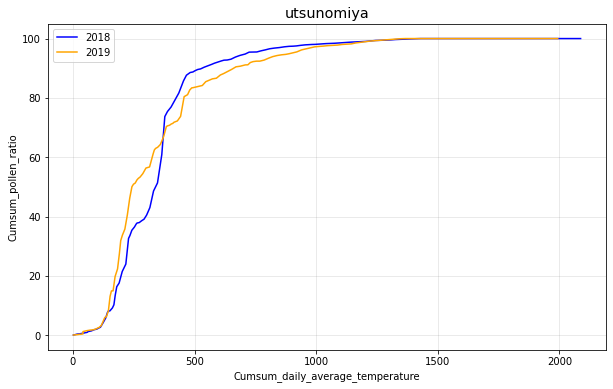

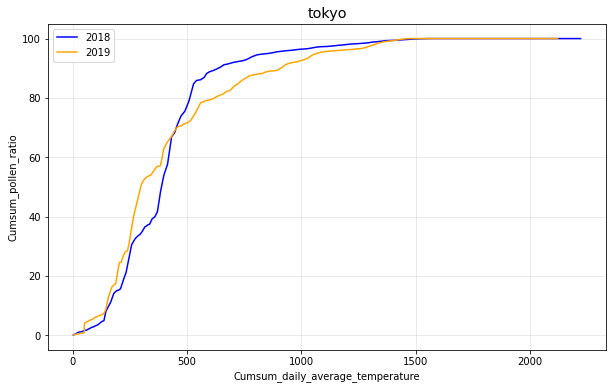

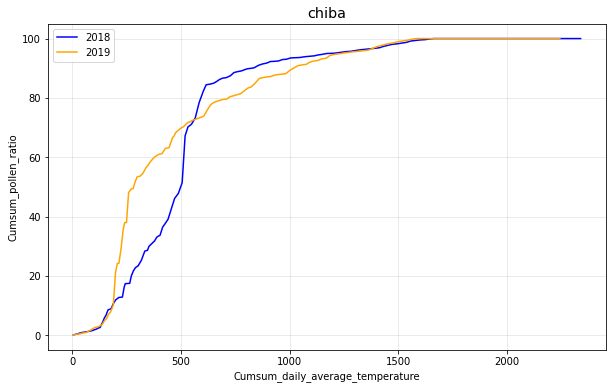

In [ ]:
years = [
    # 2017, 
    2018,
    2019,
    # 2020
]
districts = [
    "utsunomiya",
    "tokyo",
    "chiba"
]
colors = [
    # "black",
    "blue",
    "orange",
    # "red"
]

for district in districts:
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_title(district, size="x-large")
    ax.grid(alpha=0.2, color="gray")
    for year, color in zip(years, colors):
        df = dfs_daily[f"{district}_{year}"]
        ax.plot(df[f"cumsum_temperature_{district}"],
                df[f"ratio_cumsum_pollen_{district}"],
                label=year,
                color=color)
        
    ax.set_xlabel("Cumsum_daily_average_temperature")
    ax.set_ylabel("Cumsum_pollen_ratio")
    # ax2.set_ylabel("Cumsum_pollen_ratio")
    plt.legend()
    plt.show()
    print("==="*30)

# Curve Fitting

https://agriknowledge.affrc.go.jp/RN/2010762207.pdf

## Validation（2017～2019のデータ）

● Validation data: utsunomiya_2018
a: -4.9334
b: -0.0068
● Validation data: utsunomiya_2019
a: -8.2226
b: -0.0080


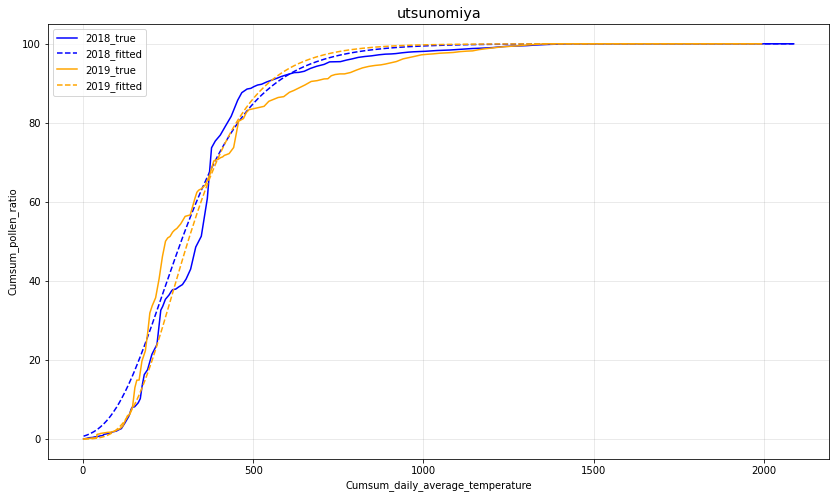

● Validation data: tokyo_2018
a: -3.8363
b: -0.0049
● Validation data: tokyo_2019
a: -6.8147
b: -0.0063


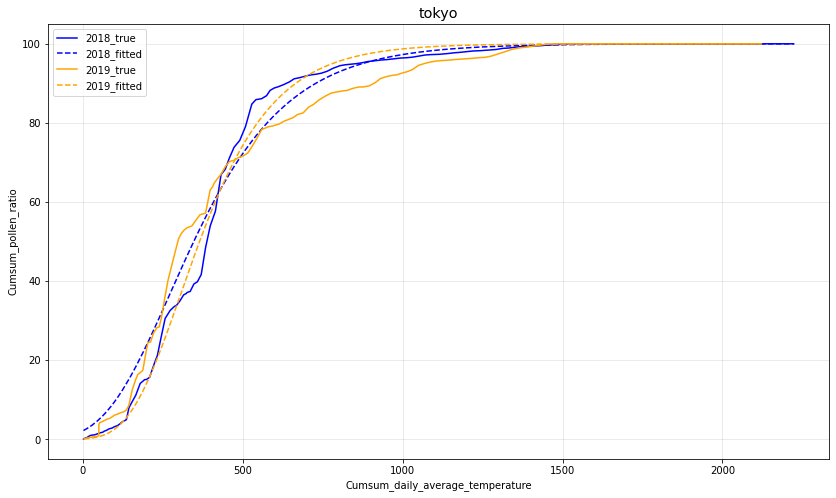

● Validation data: chiba_2018
a: -3.5067
b: -0.0044
● Validation data: chiba_2019
a: -7.1613
b: -0.0052


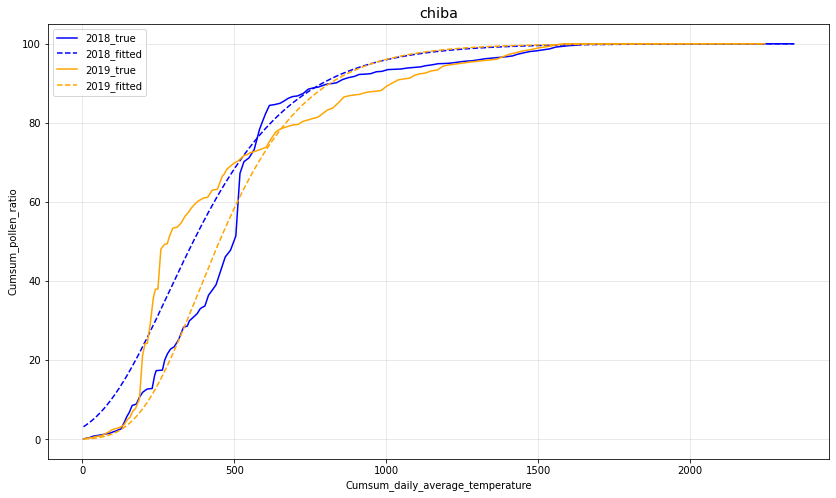

In [ ]:
def sigmoid_in_paper(x, a, b):
    y = 100 * np.exp(a * np.exp(b * x))
    return y

years = [
    # 2017, 
    2018,
    2019,
    # 2020
]
districts = [
    "utsunomiya",
    "tokyo",
    "chiba"
]
colors = [
    # "black",
    "blue",
    "orange",
    # "red"
]

for district in districts:
    fig = plt.figure(figsize=(14, 8))
    ax = fig.add_subplot()
    ax.set_title(district, size="x-large")
    ax.grid(alpha=0.2, color="gray")
    # 一度全データを結合する
    train_val = pd.concat([
        # dfs_daily[f"{district}_2017"],
        dfs_daily[f"{district}_2018"],
        dfs_daily[f"{district}_2019"],
    ])
    for year, color in zip(years, colors):
        train = train_val[~(train_val["year"]==year)]
        val = train_val[train_val["year"]==year]
        x_train = train[f"cumsum_temperature_{district}"].values
        y_train = train[f"ratio_cumsum_pollen_{district}"].values
        x_val = val[f"cumsum_temperature_{district}"].values
        y_val = val[f"ratio_cumsum_pollen_{district}"].values

        a_initial = -4.1
        b_initial = -0.017
        (a_opt, b_opt), cov = curve_fit(sigmoid_in_paper, x_train, y_train, [a_initial, b_initial])
        print(f"● Validation data: {district}_{year}")
        print(f"a: {a_opt:.4f}")
        print(f"b: {b_opt:.4f}")
        y_fit = sigmoid_in_paper(x_val, a_opt, b_opt)

        ax.plot(x_val,
                y_val,
                label=f"{year}_true",
                color=color)
        ax.plot(x_val,
                y_fit,
                label=f"{year}_fitted",
                ls="--",
                color=color)
        
    ax.set_xlabel("Cumsum_daily_average_temperature")
    ax.set_ylabel("Cumsum_pollen_ratio")
    # ax2.set_ylabel("Cumsum_pollen_ratio")
    plt.legend()
    plt.show()
    print("==="*30)

## 2020のデータにフィッティング

● Coefficients (utsunomiya, 2017-2019)
a: -6.0015
b: -0.0072
2020年における3月までの飛散量累積率: 79.63%


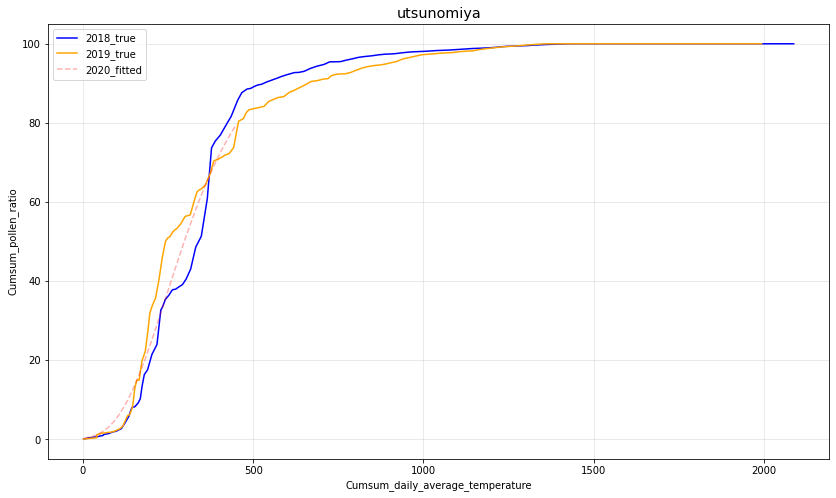

● Coefficients (tokyo, 2017-2019)
a: -4.8301
b: -0.0055
2020年における3月までの飛散量累積率: 75.49%


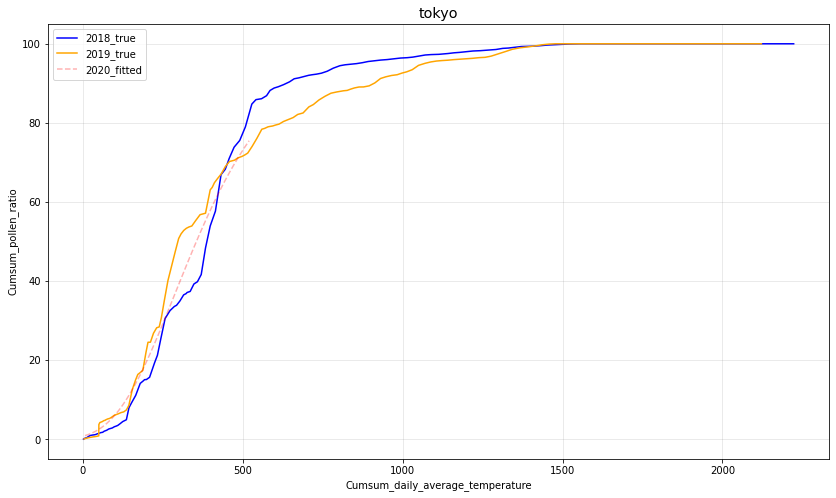

● Coefficients (chiba, 2017-2019)
a: -4.3753
b: -0.0045
2020年における3月までの飛散量累積率: 75.41%


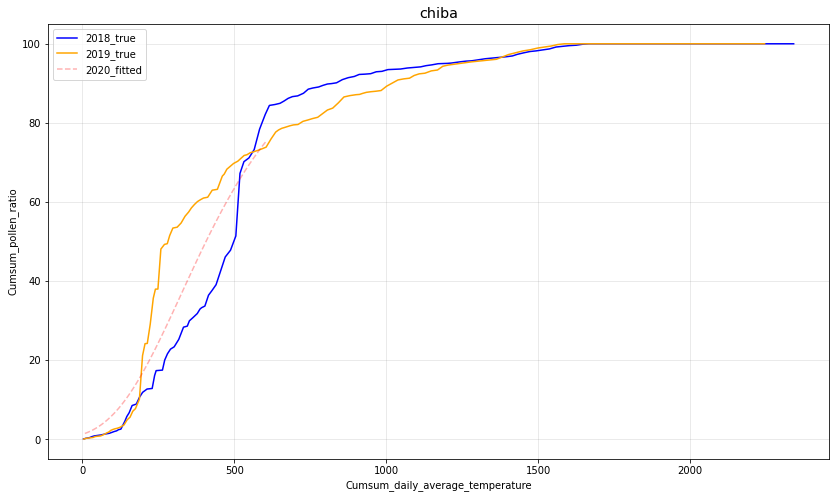

In [ ]:
def sigmoid_in_paper(x, a, b):
    y = 100 * np.exp(a * np.exp(b * x))
    return y

years = [
    # 2017, 
    2018,
    2019,
    2020
]
districts = [
    "utsunomiya",
    "tokyo",
    "chiba"
]
colors = [
    # "black",
    "blue",
    "orange",
    "red"
]

ratios_pollen_2020 = {}
for district in districts:
    fig = plt.figure(figsize=(14, 8))
    ax = fig.add_subplot()
    ax.set_title(district, size="x-large")
    ax.grid(alpha=0.2, color="gray")
    # 一度全データを結合する
    train_val = pd.concat([
        # dfs_daily[f"{district}_2017"],
        dfs_daily[f"{district}_2018"],
        dfs_daily[f"{district}_2019"],
    ])
    x_train = train_val[f"cumsum_temperature_{district}"].values
    y_train = train_val[f"ratio_cumsum_pollen_{district}"].values

    # 係数求める
    a_initial = -4.1
    b_initial = -0.017
    (a_opt, b_opt), cov = curve_fit(sigmoid_in_paper, x_train, y_train, [a_initial, b_initial])
    print(f"● Coefficients ({district}, 2017-2019)")
    print(f"a: {a_opt:.4f}")
    print(f"b: {b_opt:.4f}")

    for year, color in zip(years, colors):
        if year != 2020:
            val = train_val[train_val["year"]==year]
            x_val = val[f"cumsum_temperature_{district}"].values
            y_val = val[f"ratio_cumsum_pollen_{district}"].values
            ax.plot(x_val,
                    y_val,
                    label=f"{year}_true",
                    color=color)
        else:
            val = dfs_daily[f"{district}_2020"]
            x_val = val[f"cumsum_temperature_{district}"].values
            # フィッティング
            y_fit = sigmoid_in_paper(x_val, a_opt, b_opt)
            ratio_until_March = y_fit[-1]
            print(f"2020年における3月までの飛散量累積率: {ratio_until_March:.2f}%")
            ratios_pollen_2020[district] = ratio_until_March
            ax.plot(x_val,
                    y_fit,
                    label=f"{year}_fitted",
                    ls="--",
                    color=color,
                    alpha=0.3)
        
    ax.set_xlabel("Cumsum_daily_average_temperature")
    ax.set_ylabel("Cumsum_pollen_ratio")
    # ax2.set_ylabel("Cumsum_pollen_ratio")
    plt.legend()
    plt.show()
    print("==="*30)

In [ ]:
ratios_pollen_2020

{'utsunomiya': 79.62927081825283,
 'tokyo': 75.48756004839021,
 'chiba': 75.40874642257603}

# 各年の総飛散量を計算

In [ ]:
tgt_cols = [
    "pollen_utsunomiya",
    "pollen_chiba",
    "pollen_tokyo"
]

df_total_pollen = pd.DataFrame(columns=["utsunomiya", "chiba", "tokyo"])
for i in range(len(list_train)):
    total_pollens = []
    df = list_train.pop(0)
    year = df["year"].values[0]
    for col in tgt_cols:
        district = col[7:]
        total_pollen = df[col].sum()
        if i == 3:
            total_pollen /= (ratios_pollen_2020[district] / 100)
        total_pollens.append(total_pollen)
        df[f"ratio_{col}"] = df[col] / total_pollen
        df[f"cumsum_ratio_{col}"] = df[f"ratio_{col}"].cumsum()
    list_train.append(df)
    df_total_pollen.loc[year] = total_pollens

df_total_pollen

,utsunomiya,chiba,tokyo
2017,160265.000000,82793.000000,99023.000000
2018,477174.000000,130669.000000,143971.000000
2019,379773.000000,122643.000000,63458.000000
2020,46333.464593,32599.666705,24430.515423


In [ ]:
# df_total_pollen.to_pickle("/content/drive/MyDrive/Kaggle/花粉飛散量（ProbSpace）/proc/20230108_total_pollen_mod.pkl")

In [ ]:
tgt_cols = [
    "pollen_utsunomiya",
    "pollen_chiba",
    "pollen_tokyo"
]

dfs_daily = {}
for i in range(len(list_train)):
    df = list_train[i]
    year = df["year"].values[0]
    for col in tgt_cols:
        district = col[7:]
        tmp = df.groupby("date_int")[[col, f"temperature_{district}"]].agg({col: "sum", f"temperature_{district}": "mean"})
        tmp[f"cumsum_{col}"] = tmp[col].cumsum()
        tmp[f"cumsum_temperature_{district}"] = tmp[f"temperature_{district}"].cumsum()
        total_pollen = tmp[col].sum()
        if i == 3:
            total_pollen /= (ratios_pollen_2020[district] / 100)
        tmp[f"ratio_cumsum_{col}"] = 100 * tmp[f"cumsum_{col}"] / total_pollen
        tmp["year"] = year
        dfs_daily[f"{district}_{year}"] = tmp

tmp.head()

,pollen_tokyo,temperature_tokyo,cumsum_pollen_tokyo,cumsum_temperature_tokyo,ratio_cumsum_pollen_tokyo,year
date_int,,,,,,
20200201,44.0,6.662500,44.0,6.662500,0.180103,2020
20200202,80.0,7.691667,124.0,14.354167,0.507562,2020
20200203,192.0,8.770833,316.0,23.125000,1.293464,2020
20200204,76.0,7.395833,392.0,30.520833,1.604551,2020
20200205,108.0,6.416667,500.0,36.937500,2.046621,2020


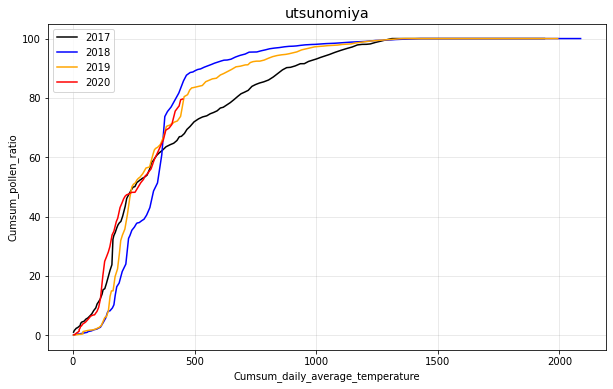

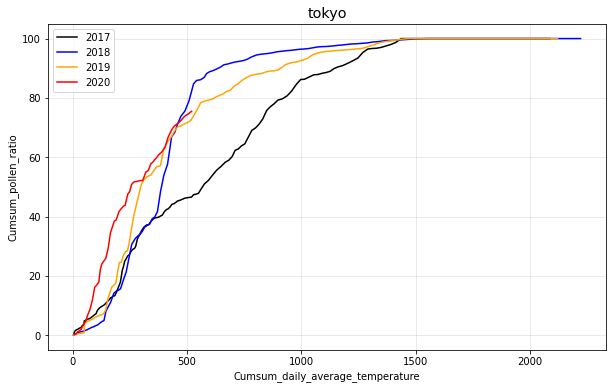

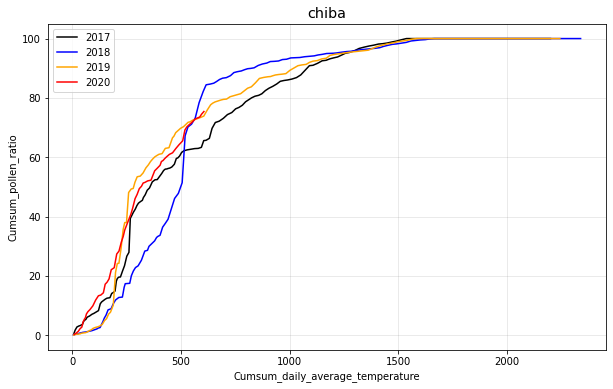

In [ ]:
years = [
    2017, 
    2018,
    2019,
    2020
]
districts = [
    "utsunomiya",
    "tokyo",
    "chiba"
]
colors = [
    "black",
    "blue",
    "orange",
    "red"
]

for district in districts:
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_title(district, size="x-large")
    ax.grid(alpha=0.2, color="gray")
    for year, color in zip(years, colors):
        df = dfs_daily[f"{district}_{year}"]
        ax.plot(df[f"cumsum_temperature_{district}"],
                df[f"ratio_cumsum_pollen_{district}"],
                label=year,
                color=color)
        
    ax.set_xlabel("Cumsum_daily_average_temperature")
    ax.set_ylabel("Cumsum_pollen_ratio")
    # ax2.set_ylabel("Cumsum_pollen_ratio")
    plt.legend()
    plt.show()
    print("==="*30)